In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score, confusion_matrix

pd.options.display.float_format = '{:,.1f}'.format

# 1. Load data

In [3]:
df = pd.read_csv('./BankChurners.csv')

As suggested in the dataset's description on Kaggle, we delete the last two columns. They won't be needed for churn prediction : https://www.kaggle.com/sakshigoyal7/credit-card-customers

In [4]:
df = df.iloc[:, :-2]

# 2. Explore and prepare data

### 2.1 First look

We start by looking at the few random rows of our table to see what the data looks like.

In [18]:
df.sample(5)

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
3386,713343333,Existing Customer,42,M,3,Unknown,Married,$40K - $60K,Blue,29,...,3,4,"6,698.0",1327,"5,371.0",0.8,4065,77,0.7,0.2
3917,719219883,Existing Customer,47,M,2,Uneducated,Married,$60K - $80K,Blue,36,...,1,2,"9,300.0",769,"8,531.0",0.7,3651,67,0.7,0.1
3171,807593058,Attrited Customer,41,F,3,Unknown,Single,$40K - $60K,Blue,36,...,2,4,"5,317.0",0,"5,317.0",0.7,2003,29,0.3,0.0
5764,714771708,Existing Customer,36,F,0,College,Unknown,Unknown,Blue,26,...,3,3,"4,692.0",0,"4,692.0",0.8,4281,69,0.6,0.0
8610,718078008,Existing Customer,40,M,2,College,Divorced,$60K - $80K,Blue,36,...,2,1,"20,304.0",0,"20,304.0",0.8,7494,85,0.7,0.0


In [5]:
print('Dataset size : '+str(df.shape))

Dataset size : (10127, 21)


We will work with 10 127 observations and 21 variables if we include the label column.

In [6]:
df.CLIENTNUM.nunique()

10127

As it is supposed to be, for all clients we have a unique identification code. We won't be able to do much with the **CLIENTNUM** column beside identifying specific clients.

### 2.2 Focus on the label column

The label column called **Attrition_Flag** contains the following values: *Existing Customer* and *Attrited Customer*

Label column distribution in our dataset:
Existing Customer    8500
Attrited Customer    1627
Name: Attrition_Flag, dtype: int64


<AxesSubplot:xlabel='Attrition_Flag', ylabel='count'>

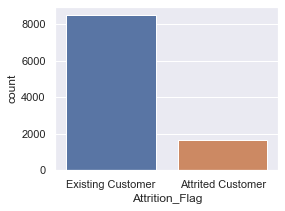

In [7]:
print('Label column distribution in our dataset:')
print(df.Attrition_Flag.value_counts())
sns.set(rc={'figure.figsize':(4,3)})
sns.countplot(data=df,x = 'Attrition_Flag')

We can observe that these two classes are quite unbalanced as we have around 5 times more existing customers than attrited ones.

For easier manipulation of the label column, we will give the value **0** to existing customers and **1** for the customers who quit the bank. 

In [8]:
df = df.replace({'Attrition_Flag' : { 'Existing Customer' : 0, 'Attrited Customer' : 1}})

### 2.3 Missing values

In [9]:
print('Number of missing values :')
print('')
print(df.isna().sum())

Number of missing values :

CLIENTNUM                   0
Attrition_Flag              0
Customer_Age                0
Gender                      0
Dependent_count             0
Education_Level             0
Marital_Status              0
Income_Category             0
Card_Category               0
Months_on_book              0
Total_Relationship_Count    0
Months_Inactive_12_mon      0
Contacts_Count_12_mon       0
Credit_Limit                0
Total_Revolving_Bal         0
Avg_Open_To_Buy             0
Total_Amt_Chng_Q4_Q1        0
Total_Trans_Amt             0
Total_Trans_Ct              0
Total_Ct_Chng_Q4_Q1         0
Avg_Utilization_Ratio       0
dtype: int64


We don't have any missing values.

### 2.4 Attribute types

In [10]:
print(df.dtypes.value_counts())
print("====================================================")
print(df.info())

int64      11
float64     5
object      5
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   CLIENTNUM                 10127 non-null  int64  
 1   Attrition_Flag            10127 non-null  int64  
 2   Customer_Age              10127 non-null  int64  
 3   Gender                    10127 non-null  object 
 4   Dependent_count           10127 non-null  int64  
 5   Education_Level           10127 non-null  object 
 6   Marital_Status            10127 non-null  object 
 7   Income_Category           10127 non-null  object 
 8   Card_Category             10127 non-null  object 
 9   Months_on_book            10127 non-null  int64  
 10  Total_Relationship_Count  10127 non-null  int64  
 11  Months_Inactive_12_mon    10127 non-null  int64  
 12  Contacts_Count_12_mon     10127 non-null  int64  
 13  Credit

We count 16 variables that are numerical (label column included), the other 5 are categorical.

In [11]:
df_num = df.select_dtypes(include=['int64','float64'])
df_cat = df.select_dtypes(include=['object'])

### 2.5 Analysis of the numerical columns

In [12]:
df_num.describe()

,CLIENTNUM,Attrition_Flag,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
count,"10,127.0","10,127.0","10,127.0","10,127.0","10,127.0","10,127.0","10,127.0","10,127.0","10,127.0","10,127.0","10,127.0","10,127.0","10,127.0","10,127.0","10,127.0","10,127.0"
mean,"739,177,606.3",0.2,46.3,2.3,35.9,3.8,2.3,2.5,"8,632.0","1,162.8","7,469.1",0.8,"4,404.1",64.9,0.7,0.3
std,"36,903,783.5",0.4,8.0,1.3,8.0,1.6,1.0,1.1,"9,088.8",815.0,"9,090.7",0.2,"3,397.1",23.5,0.2,0.3
min,"708,082,083.0",0.0,26.0,0.0,13.0,1.0,0.0,0.0,"1,438.3",0.0,3.0,0.0,510.0,10.0,0.0,0.0
25%,"713,036,770.5",0.0,41.0,1.0,31.0,3.0,2.0,2.0,"2,555.0",359.0,"1,324.5",0.6,"2,155.5",45.0,0.6,0.0
50%,"717,926,358.0",0.0,46.0,2.0,36.0,4.0,2.0,2.0,"4,549.0","1,276.0","3,474.0",0.7,"3,899.0",67.0,0.7,0.2
75%,"773,143,533.0",0.0,52.0,3.0,40.0,5.0,3.0,3.0,"11,067.5","1,784.0","9,859.0",0.9,"4,741.0",81.0,0.8,0.5
max,"828,343,083.0",1.0,73.0,5.0,56.0,6.0,6.0,6.0,"34,516.0","2,517.0","34,516.0",3.4,"18,484.0",139.0,3.7,1.0


#### A few of many interesting facts we can extract from the numerical attributes:

* **Customer_Age**: Most of our customers are middle aged people. 75% of them are older than 41yo. Standard deviation and range (max-min) are also relatively small. 

* **Dependent_count**: The number of dependents are in avarage 2.3 and never more than 5 people. The metrics indicate that most of our customers are part of small or avraged size households/families.

* **Months_on_book**: Most of the customers were in the bank for about 3 years. The most recent customer was on the book for more than a year while the person who has been with the bank for the longest will be able to celabrate a 5 year old anniversary as a cutomer of the bank (unless this person is an attrited customer).

* **Total_Relationship_Count**: The number of products held by the customer is usually at least 2 and in avarage close to 4 products. This is not very surprising as a product can be different kind of accounts, but also insurance contract or loan. 

* **Months_Inactive_12_mon**: In the last 12 months, 75% of the customers were inactive for at least two months. Also, nonone was inactive for more than 6 months.

* **Contacts_Count_12_mon**: The amount of times the cutomers were in contact with the bank is rather few for 12 months, 2.5 times in avarage. Range goes from 0 to 6.

### 2.6 Correlation matrix 

<AxesSubplot:>

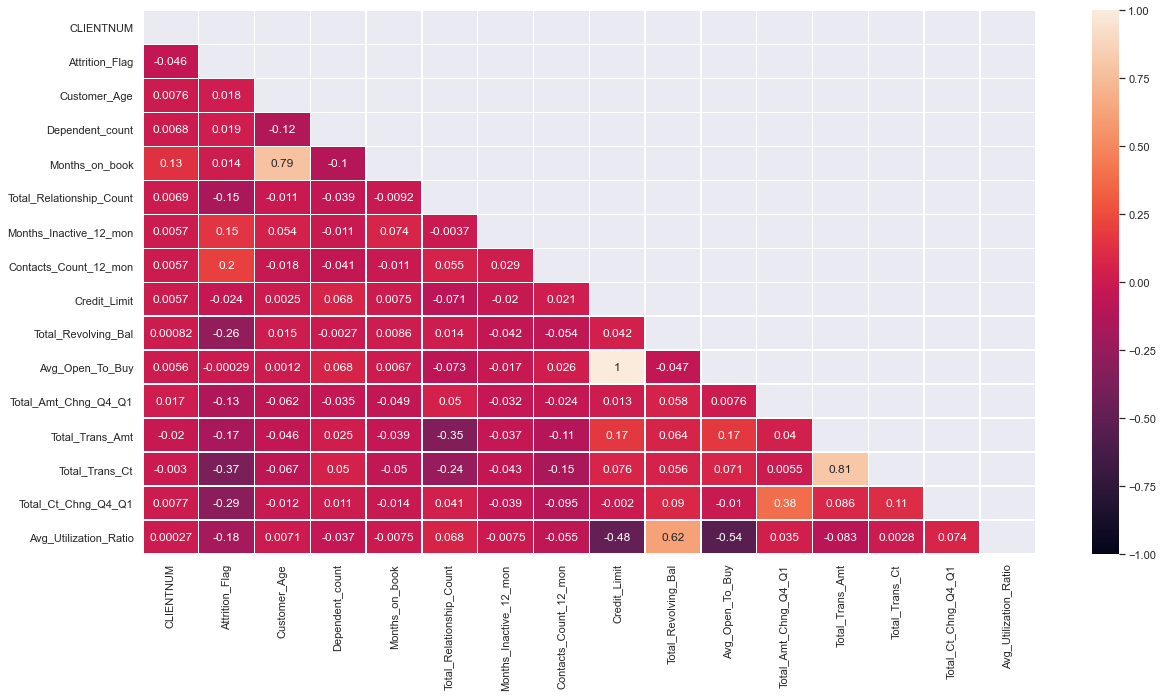

In [13]:
plt.figure(figsize=(20,10))
mask = np.zeros((df_num.shape[1],df_num.shape[1]))
mask[np.triu_indices_from(mask)] = True
sns.heatmap(df_num.corr(), annot=True, vmin=-1, vmax=1, linewidths=.5, mask = mask)

### 2.7 Analysis of the categorical columns

In [14]:
df_cat.describe()

,Gender,Education_Level,Marital_Status,Income_Category,Card_Category
count,10127,10127,10127,10127,10127
unique,2,7,4,6,4
top,F,Graduate,Married,Less than $40K,Blue
freq,5358,3128,4687,3561,9436


In [15]:
df_cat = df_cat.join(df['Attrition_Flag'])
df_cat['Attrition_Flag'] = df_cat['Attrition_Flag'].astype(str)

In [16]:
def stats_on_categ(var1,var2 = df_cat.Attrition_Flag):
    pd.options.display.float_format = '{:,.1f}'.format
    tab = pd.crosstab(var1,var2, margins = True)
    #tab['Distribution of attrited custemers by index values (%)'] = (tab['1']/tab.loc['All','1'])*100
    #tab['Part of the ("All") index value that attrited (%)'] = (tab['1']/tab.All)*100
    return tab

def stats_on_categ_visual(var1):
    sns.set(rc={'figure.figsize':(8,6)})
    tab = stats_on_categ(var1)
    tab = tab.drop(['All'], axis=1)
    return tab.plot(kind='bar', stacked=True)

Attrition_Flag     0     1    All
Gender                           
F               4428   930   5358
M               4072   697   4769
All             8500  1627  10127


<AxesSubplot:xlabel='Gender'>

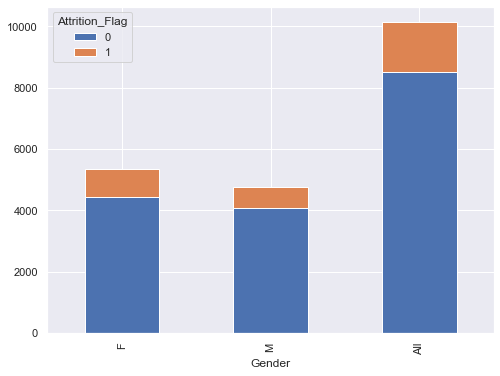

In [17]:
print(stats_on_categ(df_cat.Gender))
stats_on_categ_visual(df_cat.Gender)

Attrition_Flag      0     1    All
Education_Level                   
College           859   154   1013
Doctorate         356    95    451
Graduate         2641   487   3128
High School      1707   306   2013
Post-Graduate     424    92    516
Uneducated       1250   237   1487
Unknown          1263   256   1519
All              8500  1627  10127


<AxesSubplot:xlabel='Education_Level'>

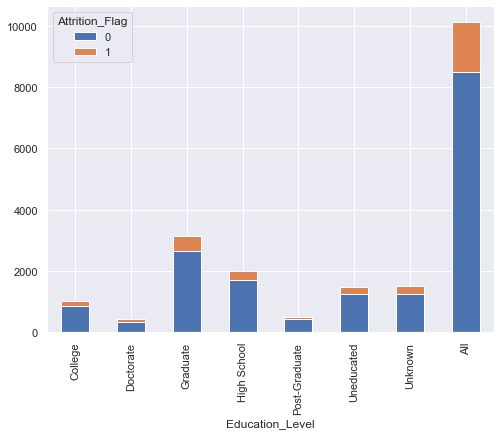

In [18]:
print(stats_on_categ(df_cat.Education_Level))
stats_on_categ_visual(df_cat.Education_Level)

Attrition_Flag     0     1    All
Marital_Status                   
Divorced         627   121    748
Married         3978   709   4687
Single          3275   668   3943
Unknown          620   129    749
All             8500  1627  10127


<AxesSubplot:xlabel='Marital_Status'>

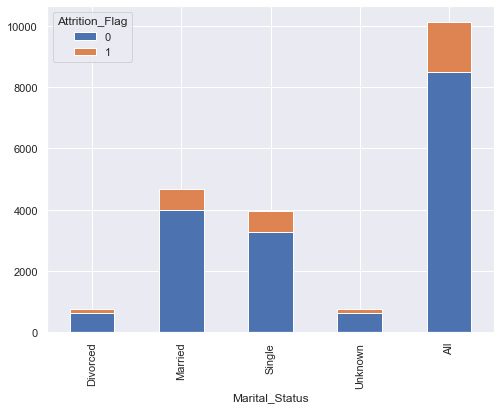

In [19]:
print(stats_on_categ(df_cat.Marital_Status))
stats_on_categ_visual(df_cat.Marital_Status)

Attrition_Flag      0     1    All
Income_Category                   
$120K +           601   126    727
$40K - $60K      1519   271   1790
$60K - $80K      1213   189   1402
$80K - $120K     1293   242   1535
Less than $40K   2949   612   3561
Unknown           925   187   1112
All              8500  1627  10127


<AxesSubplot:xlabel='Income_Category'>

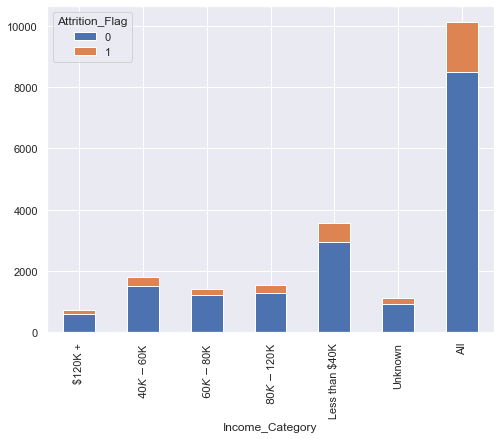

In [20]:
print(stats_on_categ(df_cat.Income_Category))
stats_on_categ_visual(df_cat.Income_Category)

Attrition_Flag     0     1    All
Card_Category                    
Blue            7917  1519   9436
Gold              95    21    116
Platinum          15     5     20
Silver           473    82    555
All             8500  1627  10127


<AxesSubplot:xlabel='Card_Category'>

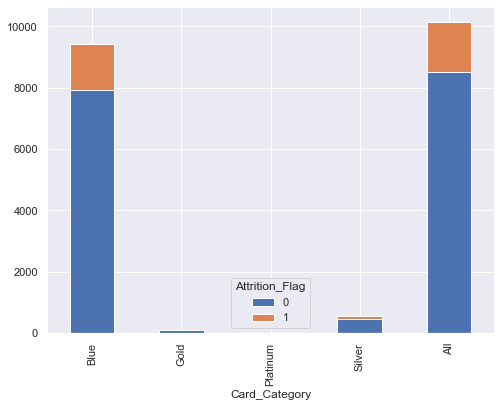

In [21]:
print(stats_on_categ(df_cat.Card_Category))
stats_on_categ_visual(df_cat.Card_Category)

# 3. Creating a validation and a train/test dataset

Before injecting our data into our model, we set apart around 10% of our data that we won't use during the traing. This will allow us to test the performance of our model on completely unseen data.

The data that will be used for the model training will be split up into train and test.

Before these steps, we randomly shuffle our records to avoid selection bias.

In [22]:
df = df.sample(frac=1,random_state=1).reset_index(drop=True)

In [23]:
df = df.set_index('CLIENTNUM') # customer ID won't be used for churn prediction

In [24]:
df_train = df.iloc[0:9000,:]
df_valid = df.iloc[9000:,:]

In [25]:
target_train = df_train.Attrition_Flag
target_valid = df_valid.Attrition_Flag

data_train = df_train.drop(['Attrition_Flag'],axis = 1)
data_valid = df_valid.drop(['Attrition_Flag'],axis = 1)

In [26]:
X_train, X_test, y_train, y_test = train_test_split(data_train, target_train, test_size=0.20, random_state= 7)

# 4.Transforming categorical attributes into dummies

In [27]:
X_train_dummy = pd.get_dummies(X_train)
X_test_dummy = pd.get_dummies(X_test)

# verify if we have the same columns in train and test dataset
assert X_train_dummy.columns.equals(X_test_dummy.columns)

# 5. Standard scaling our data

In [28]:
scaler = StandardScaler()
scaler.fit(X_train_dummy)

X_train_sc = pd.DataFrame(scaler.transform(X_train_dummy), columns = X_train_dummy.columns)
X_test_sc = pd.DataFrame(scaler.transform(X_test_dummy), columns = X_train_dummy.columns)

# 6.Training a Random Forest model

In [29]:
%%time 

param_rf = {
    'bootstrap': [True],
    'max_depth': [10,11,12,13],
    'max_features': [10,11,12,13,14],
    'n_estimators': [400,500,600,700]
}


clf_rf = RandomForestClassifier()

grid_rf = GridSearchCV(clf_rf, param_rf, cv = 5, n_jobs = -1)
grid_rf.fit(X_train_sc,y_train)
print(grid_rf.best_estimator_)

RandomForestClassifier(max_depth=13, max_features=13, n_estimators=700)
CPU times: user 10.3 s, sys: 217 ms, total: 10.6 s
Wall time: 12min 40s


# 7. Evaluate classification performance

In [30]:
def evaluate_perf(y_test,y_pred):
    print(pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted']))
    print('====================')
    print("Accuracy : ", "{:.2f}".format(accuracy_score(y_test,y_pred)))
    print("Precision : ", "{:.2f}".format(precision_score(y_test,y_pred)))
    print("Recall : ","{:.2f}".format(recall_score(y_test,y_pred)))
    print("F1 :", "{:.2f}".format(f1_score(y_test,y_pred)))

In [31]:
y_pred_rf = grid_rf.predict(X_test_sc)
evaluate_perf(y_test,y_pred_rf)

Predicted     0    1
Actual              
0          1492   21
1            49  238
Accuracy :  0.96
Precision :  0.92
Recall :  0.83
F1 : 0.87


# 8. Validation of the model performance

In [32]:
data_valid_dummy = pd.get_dummies(data_valid)
assert X_train_dummy.columns.equals(data_valid_dummy.columns)

In [33]:
data_valid_sc = pd.DataFrame(scaler.transform(data_valid_dummy), columns = data_valid_dummy.columns)

In [34]:
valid_pred_rf = grid_rf.predict(data_valid_sc)
evaluate_perf(target_valid,valid_pred_rf)

Predicted    0    1
Actual             
0          935   13
1           26  153
Accuracy :  0.97
Precision :  0.92
Recall :  0.85
F1 : 0.89


# 9. Explainability and feature selection

In [35]:
pd.options.display.float_format = '{:,.3f}'.format
feature_imp = pd.DataFrame(data=[X_train_sc.columns.tolist(), grid_rf.best_estimator_.feature_importances_]).T
feature_imp.columns = ['feature','importance']
feature_imp.sort_values('importance',ascending=False)

,feature,importance
11,Total_Trans_Ct,0.196
10,Total_Trans_Amt,0.191
7,Total_Revolving_Bal,0.128
12,Total_Ct_Chng_Q4_Q1,0.105
3,Total_Relationship_Count,0.078
13,Avg_Utilization_Ratio,0.055
9,Total_Amt_Chng_Q4_Q1,0.055
0,Customer_Age,0.03
8,Avg_Open_To_Buy,0.025
6,Credit_Limit,0.023
